###  1. Carregar o Modelo e Configurar o Ambiente

In [1]:
# --- IMPORTS ---
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

# --- DRIVE & PATHS ---
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/MVTec_Anomaly_Detection'
CHOSEN_CATEGORY = 'bottle'
dataset_root = os.path.join(project_path, 'datasets', CHOSEN_CATEGORY)
test_dir = os.path.join(dataset_root, 'test')
model_path = os.path.join(project_path, f'{CHOSEN_CATEGORY}_autoencoder_best.pth')


# --- CONFIGURAÇÕES ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256
BATCH_SIZE = 16

# --- RECRIA A ARQUITETURA DO MODELO (O CÓDIGO DEVE SER IDÊNTICO AO DO NOTEBOOK DE TREINO) ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # ... (COLE AQUI EXATAMENTE A MESMA CLASSE 'ConvAutoencoder' DO NOTEBOOK ANTERIOR) ...
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1); self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1); self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1); self.pool3 = nn.MaxPool2d(2, 2)
        self.t_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2)
    def forward(self, x):
        x = torch.relu(self.conv1(x)); x = self.pool1(x); x = torch.relu(self.conv2(x)); x = self.pool2(x)
        x = torch.relu(self.conv3(x)); x = self.pool3(x); x = torch.relu(self.t_conv1(x))
        x = torch.relu(self.t_conv2(x)); x = torch.sigmoid(self.t_conv3(x)); return x

# --- CARREGA O MODELO E OS PESOS ---
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval() # IMPORTANTE: Coloca o modelo em modo de avaliação

print("Modelo carregado com sucesso e pronto para avaliação.")

Mounted at /content/drive
Modelo carregado com sucesso e pronto para avaliação.


### 2. Calcular Erros de Reconstrução no Conjunto de Teste

In [2]:
# --- PREPARA O DATALOADER DE TESTE (repetido para garantir) ---
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transforms
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # importante manter shuffle=False para avaliação
)

# --- CALCULA OS ERROS ---
reconstruction_errors = []
true_labels = []
criterion = nn.MSELoss() # Usamos a mesma função de perda para medir o erro

print("Calculando o erro de reconstrução para cada imagem de teste...")

with torch.no_grad(): # Garante que não estamos calculando gradientes
    for images, labels in test_loader:
        images = images.to(DEVICE)

        # Obtém as reconstruções do modelo
        reconstructions = model(images)

        # Calcula o erro para cada imagem no lote individualmente
        for i in range(len(images)):
            # Compara a imagem original com a reconstruída
            error = criterion(reconstructions[i], images[i])
            reconstruction_errors.append(error.item())
            true_labels.append(labels[i].item())

print(f"Cálculo de erros concluído. {len(reconstruction_errors)} erros calculados.")
# (O número de erros deve ser igual ao total de imagens de teste)

Calculando o erro de reconstrução para cada imagem de teste...
Cálculo de erros concluído. 83 erros calculados.


### 3. Encontrar o Limiar (Threshold) Ideal

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np

# Converte nossas listas para arrays numpy para facilitar os cálculos
errors = np.array(reconstruction_errors)
labels = np.array(true_labels)

# No dataset MVTec, a etiqueta '0' é para imagens normais ('good').
# Qualquer outra etiqueta (1, 2, etc.) é um tipo de anomalia.
# Vamos converter as etiquetas para um formato binário: 0 = normal, 1 = anomalia.
binary_labels = (labels > 0).astype(int)

# Inicializa variáveis para guardar o melhor resultado
best_accuracy = 0
best_threshold = 0

# Testa um grande número de thresholds possíveis entre o menor e o maior erro
for threshold in np.linspace(np.min(errors), np.max(errors), num=1000):

    # Gera as previsões: se o erro for maior que o threshold, é uma anomalia (1)
    predictions = (errors > threshold).astype(int)

    # Calcula a acurácia para este threshold
    accuracy = accuracy_score(binary_labels, predictions)

    # Se a acurácia for a melhor que já vimos, guarda o threshold e a acurácia
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print("Busca pelo melhor threshold concluída.")
print("-----------------------------------------")
print(f"Melhor Threshold Encontrado: {best_threshold:.6f}")
print(f"Acurácia com este threshold: {best_accuracy*100:.2f}%")

Busca pelo melhor threshold concluída.
-----------------------------------------
Melhor Threshold Encontrado: 0.000603
Acurácia com este threshold: 75.90%


### 4. Visualizar os Resultados

--- Exemplo de Imagem Normal ---


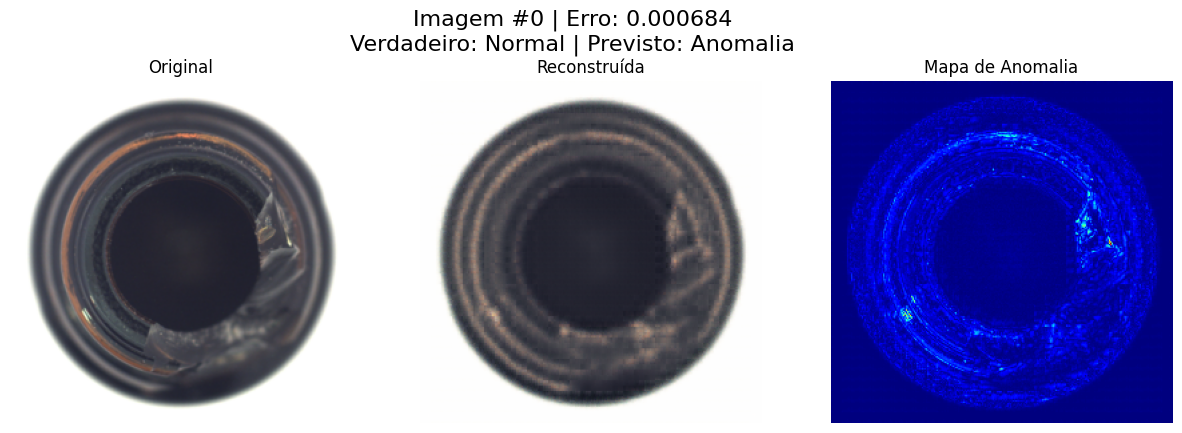


--- Exemplo de Imagem com Anomalia ---


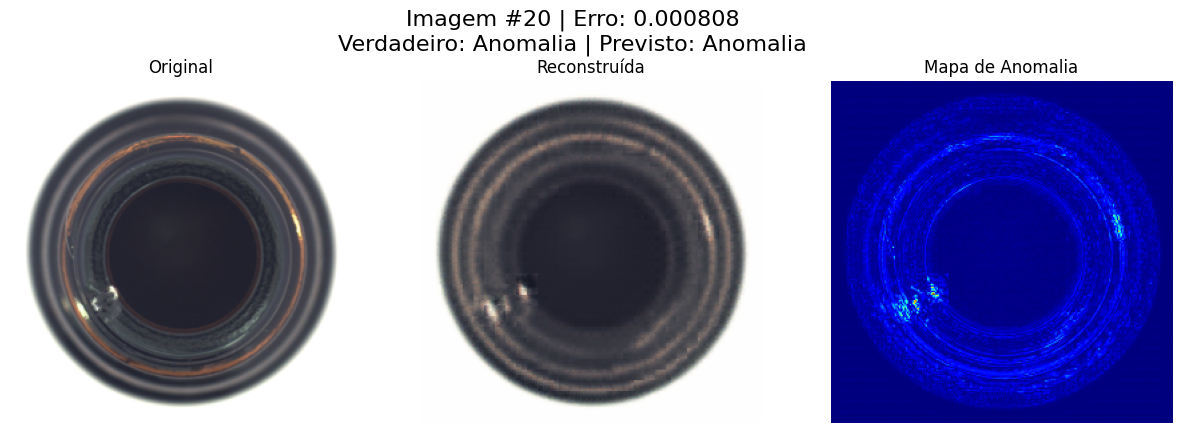

In [4]:
# Garante que as variáveis `best_threshold`, `binary_labels` e `errors` estão disponíveis
# (elas foram criadas na Célula 3)

def visualize_predictions(dataset_indices):
    """
    Função para visualizar as previsões do modelo para índices específicos do dataset de teste.
    """
    for idx in dataset_indices:
        # Pega a imagem e a etiqueta original
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(DEVICE) # Adiciona uma dimensão de lote e envia para a GPU

        # Passa a imagem pelo modelo
        with torch.no_grad():
            reconstruction = model(image)

        # Calcula o mapa de anomalia (diferença) e converte para escala de cinza
        anomaly_map = torch.mean(torch.abs(image - reconstruction), dim=1, keepdim=True)

        # Pega o erro de reconstrução e a etiqueta que já calculamos
        error = errors[idx]
        true_label = "Anomalia" if binary_labels[idx] == 1 else "Normal"

        # Faz a previsão com base no nosso threshold
        prediction = "Anomalia" if error > best_threshold else "Normal"

        # Prepara imagens para plotagem
        original_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
        reconstructed_img = reconstruction.squeeze().cpu().permute(1, 2, 0).numpy()
        anomaly_map_img = anomaly_map.squeeze().cpu().numpy()

        # Plota os resultados
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Imagem #{idx} | Erro: {error:.6f}\nVerdadeiro: {true_label} | Previsto: {prediction}", fontsize=16)

        axs[0].imshow(original_img)
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(reconstructed_img)
        axs[1].set_title("Reconstruída")
        axs[1].axis('off')

        axs[2].imshow(anomaly_map_img, cmap='jet')
        axs[2].set_title("Mapa de Anomalia")
        axs[2].axis('off')

        plt.show()

# --- EXECUTA A VISUALIZAÇÃO ---
# Encontra o índice da primeira imagem Normal e da primeira com Anomalia no conjunto de teste
idx_normal = np.where(binary_labels == 0)[0][0]
idx_anomalia = np.where(binary_labels == 1)[0][0]

print("--- Exemplo de Imagem Normal ---")
visualize_predictions([idx_normal])

print("\n--- Exemplo de Imagem com Anomalia ---")
visualize_predictions([idx_anomalia])